# Creates an MS-COCO style dataset for powerpoint

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</s}tyle>"))

In [2]:
# win32 com
#http://www.s-anand.net/blog/automating-powerpoint-with-python/
#https://docs.microsoft.com/en-us/office/vba/api/powerpoint.fillformat.visible
import win32com.client
import os
import random
import numpy as np
import PIL
from tqdm import tqdm
import random 
import lib
from natsort import natsorted

In [3]:
Application = win32com.client.Dispatch('PowerPoint.Application')
slide_height, slide_width = 540, 960
IMAGE_RES_DIVISOR = 1

In [4]:
part_x, part_y = (slide_height/IMAGE_RES_DIVISOR)/32, (slide_width/IMAGE_RES_DIVISOR)/32 
print(part_x*part_y, part_x, part_y)

506.25 16.875 30.0


In [6]:
from importlib import reload
from lib.ppt_interface import PPT_shapes, add_shape, add_line, add_title, add_textBox, convert_line_xyhw_to_points
reload(lib)
reload(lib.ppt_interface)

shape_manager = PPT_shapes()

In [7]:
# Alright, lets generate some training data!

choices = [
             'TextBox',
             'StraightConnector',
             'Rectangle',
             'LeftArrow',
             'Chevron',
             'Oval',
             'Donut',
             'IsoscelesTriangle',
        ]


def make_training_data_slide():
    slide = Presentation.Slides.Add(1, 11)
    
    # Put some text in the title
    slide.shapes.Title.TextFrame.TextRange.Text = "Title"
#     slide.Shapes.Title.delete()
    
    num_shapes = np.random.randint(5,10) 
    
    for s in range(0,num_shapes):
        choice = np.random.choice(choices)
        
        info = shape_manager.shapes[choice]
        if info[1] == 'line':
            # either horizontal or vertical only
            if np.random.uniform() < 0.5: # vertical
                x1, y1 = np.random.uniform(0.2,0.9), np.random.uniform(0.2,0.5)
                x2 = x1
                y2 = y1 + min(np.random.uniform(0.3,0.6), 1-y1)
            else: # vertical
                x1, y1 = np.random.uniform(0.2,0.5), np.random.uniform(0.2,0.9)
                y2 = y1
                x2 = x1 + min(np.random.uniform(0.3,0.6), 1-x1)
            
            x1,x2, y1,y2 = x1*slide_width, x2*slide_width, y1*slide_height, y2*slide_height
            add_line(slide, x1,y1,x2,y2)
        else:
            x = np.random.uniform(0.2,0.8)
            y = np.random.uniform(0.2,0.7)
            h = min(np.random.uniform(0.05,0.2), 1-y)
            w = min(np.random.uniform(0.05,0.3), 1-x) # don't want it bigger than the frame

            x,w, y,h = x*slide_width, w*slide_width, y*slide_height, h*slide_height

            rgb = np.zeros(3) # default 0
            border = 0 #default 0 
            fill = 1# np.random.randint(2)
            if fill == 1:
                col = np.random.randint(3)
                rgb[col] = 1 # literally only do r, g or b at the moment. This isn't a color accuracy test
            else:
                border = 1 # if not filled, then do a border
            text = 0# np.random.randint(2)

            ####################################
            if info[1] == 'textBox':
                add_textBox(slide, x,y,h,w)
            if info[1] == 'shape':
                add_shape(slide, info[0], x,y,h,w, rgb, border, fill,text)
        
    return slide

In [8]:
# Presentation = Application.Presentations.Add()
# slide = Presentation.Slides.Add(1, 11)
# add_shape(slide, 1, 0,520,20,20, [0,0,0])

In [9]:
#Presentation = Application.Presentations.Open(os.getcwd()+ '\\Presentation.pptx') # need full path with win22com
# Create a new ppt deck


# Make the deck of examples

In [10]:
def try_dir(path):
    try:
        os.makedirs(path)
    except Exception as e:
        print(e)
        pass


In [11]:
train_path =  os.getcwd()+ '\\data\\rgb_ppt\\train'
val_path =  os.getcwd()+ '\\data\\rgb_ppt\\val'
path = train_path
deck_path = path + '/decks/'
try_dir(deck_path)


[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\Sholto Douglas\\Desktop\\artificial_graphics\\data\\rgb_ppt\\train/decks/'


In [507]:
existing_presos = len(os.listdir(path+'/decks/'))
N_PRESOS = existing_presos+200
for p in tqdm(range(existing_presos, N_PRESOS)):
    Presentation = Application.Presentations.Add()
    for i in range(0,40):
        make_training_data_slide() 
    Presentation.saveAs(path+f'/decks/{p}')
    Presentation.close()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [28:15<00:00,  8.48s/it]


# Save images to disk

In [508]:
images = []
annotations = []

counter = 0
anno_counter = 0
for p in natsorted(os.listdir(path+'/decks/')):
    if '~' in p: # don't want the intermediate checkpoints
        continue
    Presentation = Application.Presentations.Open(f'{path}\\decks\\' + p)
    # Make a dir for the images from tha
    for i,slide in tqdm(enumerate(Presentation.Slides)):
        readout = read_slide(slide)
        slide.Export(path+f"/{counter}.jpg", 'JPG', slide_width, slide_height)
        images.append({
            "id": counter,
            "file_name": f"{counter}.jpg",
            "width": slide_width,
            "height": slide_height,
            "date_captured":  "2021-06-20 01:55:23.687250",
            "license": 1,
            "coco_url": "",
            "flickr_url": "",
        })
        for anno in readout:
            annotations.append({
                "id": anno_counter,
                "image_id": counter,
                "category_id": anno['class'],
                "iscrowd": 0,
                "area": anno['height']*anno['width'],
                "bbox": [anno['left'], anno['top'], anno['width'], anno['height']],
                "segmentation": [],
                
            })
            anno_counter += 1
        
        counter += 1
        
    Presentation.close()

40it [00:09,  4.28it/s]
40it [00:09,  4.32it/s]
40it [00:09,  4.44it/s]
40it [00:09,  4.36it/s]
40it [00:08,  4.56it/s]
40it [00:09,  4.32it/s]
40it [00:09,  4.05it/s]
40it [00:08,  4.76it/s]
40it [00:09,  4.18it/s]
40it [00:09,  4.31it/s]
40it [00:09,  4.36it/s]
40it [00:09,  4.27it/s]
40it [00:09,  4.19it/s]
40it [00:08,  4.63it/s]
40it [00:08,  4.71it/s]
40it [00:09,  4.12it/s]
40it [00:08,  4.53it/s]
40it [00:08,  4.55it/s]
40it [00:09,  4.16it/s]
40it [00:09,  4.27it/s]
40it [00:10,  3.93it/s]
40it [00:10,  3.68it/s]
40it [00:11,  3.62it/s]
40it [00:10,  3.99it/s]
40it [00:10,  3.79it/s]
40it [00:10,  3.90it/s]
40it [00:10,  3.73it/s]
40it [00:10,  3.70it/s]
40it [00:10,  3.71it/s]
40it [00:10,  3.66it/s]
40it [00:10,  3.74it/s]
40it [00:11,  3.64it/s]
40it [00:10,  3.74it/s]
40it [00:11,  3.60it/s]
40it [00:11,  3.57it/s]
40it [00:11,  3.58it/s]
40it [00:10,  3.75it/s]
40it [00:10,  3.77it/s]
40it [00:11,  3.58it/s]
40it [00:10,  3.91it/s]
40it [00:10,  3.76it/s]
40it [00:10,  3.

In [509]:
import json
data =  {
    "info":           {
                      "description": "PPTAI",
                      "url": "sholtodouglas.github.io",
                      "version": "0.1.0",
                      "year": 2021,
                      "contributor": "sholtodouglas",
                      "date_created": "2021-06-20 01:55:39.314230"
                      },
    "licenses": [
                  {
                      "id": 1,
                      "name": "Mine",
                      "url": "Mine"
                  }
                ],
    "categories" : [],
    "images": images,
    "annotations": annotations,
}

for name, ID in shape_manager.classIDs.items():
    data['categories'].append({'id': ID, 'name':name, 'supercategory':"N/A"})
json_object = json.dumps(data, indent = 4)  
print(json_object) 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [510]:
if "train" in path:
    with open(f'{path}//custom_train.json', 'w') as f:
        json.dump(data, f)
else:
    with open(f'{path}//custom_val.json', 'w') as f:
        json.dump(data, f)

In [447]:
# gsutil -m cp -r data/rgb_ppt/ gs://lfp_europe_west4_a/data/

In [12]:
DATA_BASE = 'data/rgb_ppt/'

In [471]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["target"][0] # remove batch dimension

        return pixel_values, target

In [472]:
# Based on the class defined above, we create training and validation datasets.
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=f'{DATA_BASE}/train', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=f'{DATA_BASE}/val', feature_extractor=feature_extractor, train=False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [473]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 410
Number of validation examples: 40


Image n°367


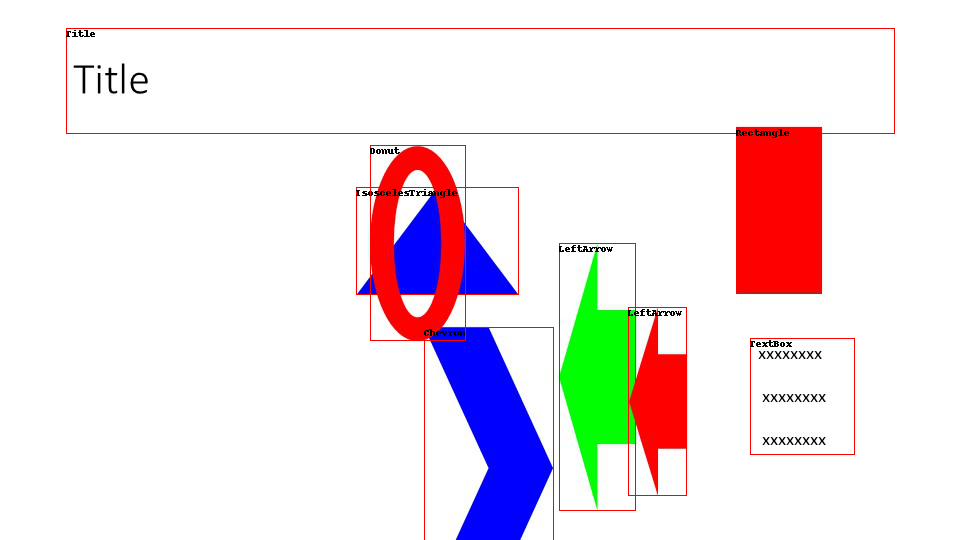

In [478]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{DATA_BASE}/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='black')

image

In [17]:
f'{DATA_BASE}/train//' + os.listdir(f'{DATA_BASE}/train')[0]

'data/rgb_ppt//train//0.jpg'